# Обучение с учителем. Извлечение признаков. Практика с набором данных Titanic

**Рассмотрим пример создания признаков с [набором данных](https://www.kaggle.com/c/titanic) "Titanic".**

In [96]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn import preprocessing, neighbors
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
%pylab inline
import seaborn as sns
figsize(12, 8)

Populating the interactive namespace from numpy and matplotlib


**Функция для формирования csv-файла посылки на Kaggle**

In [97]:
def write_to_submission_file(predicted_labels, out_file, train_num=891,
                    target='Survived', index_label="PassengerId"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(train_num + 1,
                                                  train_num + 1 +
                                                  predicted_labels.shape[0]),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

**Считываем обучающую и тестовую выборки**

In [98]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [99]:
y = train_df['Survived']

In [100]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [101]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [102]:
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


Заполним пропуски медианными значениями

In [103]:
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].mean())
test_df['Age'] = test_df['Age'].fillna(test_df['Age'].mean())

**Кодируем категориальный признак "Sex"**

In [104]:
sex_encoder = LabelEncoder()
sex_encoder.fit(train_df['Sex'])

LabelEncoder()

**Составим обучающую и тестовую выборки**

In [105]:
X_train = train_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']]
X_train['Sex'] = sex_encoder.fit_transform(X_train['Sex'])
X_train.head()

,Pclass,Sex,Age,SibSp,Parch
0,3,1,22.0,1,0
1,1,0,38.0,1,0
2,3,0,26.0,0,0
3,1,0,35.0,1,0
4,3,1,35.0,0,0


In [106]:
X_test = test_df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']]
X_test['Sex'] = sex_encoder.fit_transform(X_test['Sex'])
X_test.head()

,Pclass,Sex,Age,SibSp,Parch
0,3,1,34.5,0,0
1,3,0,47.0,1,0
2,2,1,62.0,0,0
3,3,1,27.0,0,0
4,3,0,22.0,1,1


In [107]:
y = train_df['Survived']
y.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [108]:
# parameter combinations to try
# parameter combinations to try
n = neighbors.KNeighborsClassifier()
n.fit(X_train, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

**Эта посылка получила на Kaggle 0.76555**

In [109]:
predicted_labels = n.predict(X_test)

In [110]:
write_to_submission_file(predicted_labels, 'titanic_knn.csv')

In [111]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Теперь можно настроить параметры поточнее. Но сначала посмотрим, как можно добавить признак "Title", "вытащив" его из имени.** 

In [112]:
def parse_title(name):
    """
    Takes name in a form "Lastname, title. name"
    and returns title
    """
    return name.split(',')[1].split('.')[0].strip()

train_df['Title'] = [parse_title(name) for name in train_df['Name']]
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [113]:
train_df['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Mme               1
Capt              1
Ms                1
Lady              1
Sir               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

**Распределение признака "Title"**

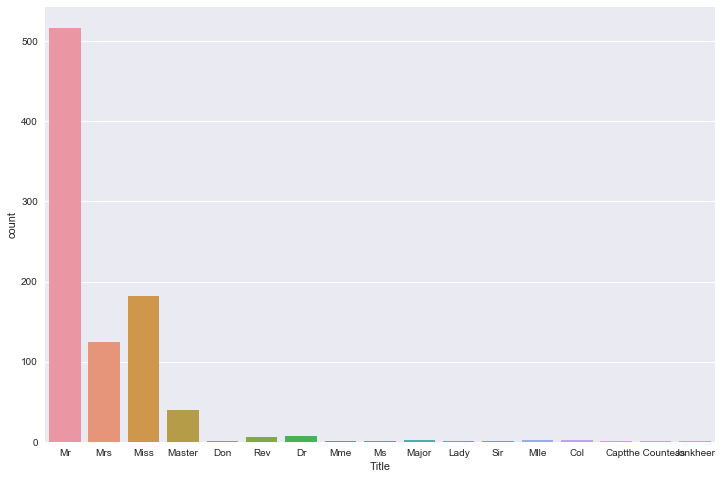

In [114]:
sns.countplot(train_df['Title'])

In [115]:
titles = train_df['Title'].value_counts()
titles

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Mme               1
Capt              1
Ms                1
Lady              1
Sir               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

**Посмотрим на имя, пол и возраст пассажиров с редкими обращениями**

In [116]:
rare_titles = titles[titles < 10]
criterion = train_df['Title'].map(lambda title: 
                                  title in rare_titles.index)
train_df[criterion][['Name', 'Sex', 'Age', 'Title']].sort_values(by='Title')

,Name,Sex,Age,Title
745,"Crosby, Capt. Edward Gifford",male,70.000000,Capt
694,"Weir, Col. John",male,60.000000,Col
647,"Simonius-Blumer, Col. Oberst Alfons",male,56.000000,Col
30,"Uruchurtu, Don. Manuel E",male,40.000000,Don
766,"Brewe, Dr. Arthur Jackson",male,29.699118,Dr
317,"Moraweck, Dr. Ernest",male,54.000000,Dr
398,"Pain, Dr. Alfred",male,23.000000,Dr
660,"Frauenthal, Dr. Henry William",male,50.000000,Dr
796,"Leader, Dr. Alice (Farnham)",female,49.000000,Dr
632,"Stahelin-Maeglin, Dr. Max",male,32.000000,Dr


**Посмотрим распределение возрастов в зависимости от обращения**

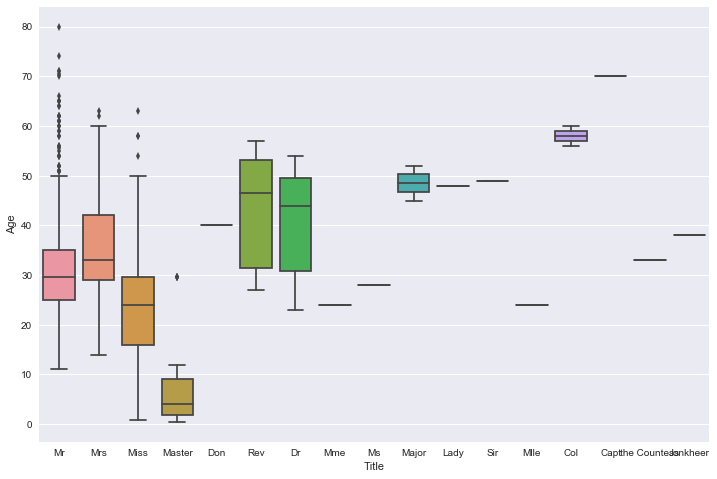

In [117]:
sns.boxplot(x="Title", y='Age', data=train_df)

**Объединим редкие "Capt", "Sir", "Don", "Col", "Major", "Rev", "Jonkheer" и "Dr" c "Mr", а "the Countess", "Mlle", "Lady" и "Ms" - c "Mrs".**

In [118]:
def merge_titles(title):
    if title in ("Capt", "Sir", "Don", 
                "Col", "Major", "Rev", 
                "Jonkheer","Dr"):
        return "Mr"
    elif title in ("the Countess", "Mlle", "Mme", "Lady", "Ms"):
        return "Mrs"
    else:
        return title

train_df['Title'] = train_df['Title'].map(merge_titles)
train_df['Title'].value_counts()

Mr        538
Miss      182
Mrs       131
Master     40
Name: Title, dtype: int64

**Выделяются возрастные группы по обращениям "Master" и "Miss". Чуть менее видна разница между "Mr" и "Mrs".**

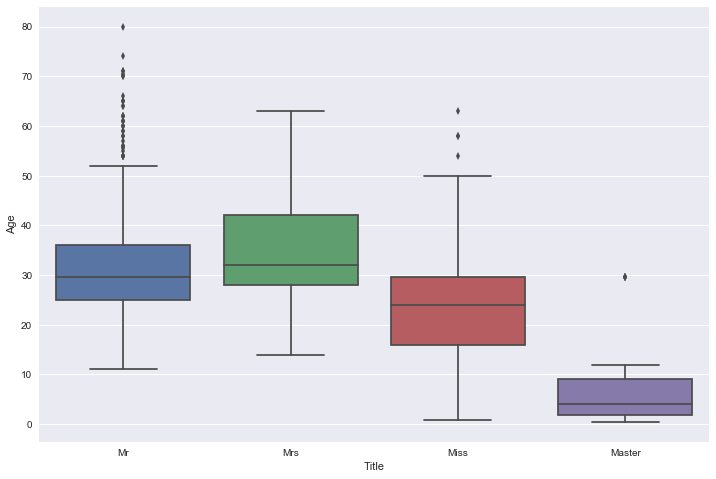

In [119]:
sns.boxplot(x="Title", y='Age', data=train_df)

**Составим выборки с признаком "Title" вместо "Age"**

In [120]:
X_train.head(2)

,Pclass,Sex,Age,SibSp,Parch
0,3,1,22.0,1,0
1,1,0,38.0,1,0


In [121]:
train_df['Title'] = train_df['Name'].map(parse_title)\
                                    .map(merge_titles)
test_df['Title'] = test_df['Name'].map(parse_title)\
                                    .map(merge_titles)
# encode categorical 'Title'
title_encoder = LabelEncoder()
# scikit's bug. If there is a new label in a test set, encoder
# doesn't know what to do with it
title_encoder.fit(train_df['Title'].append(test_df['Title']))

X_train['Title'] = title_encoder.transform(train_df['Name']
                                           .map(parse_title)
                                           .map(merge_titles))
X_test['Title'] = title_encoder.transform(test_df['Name']
                                          .map(parse_title)
                                          .map(merge_titles))

**Удалим из обучающей и тестовой выборок признак "Age" и посмотрим на выборки перед обучением случайного леса.**

In [132]:
X_train = X_train.drop('Age', 1)

In [133]:
X_train.head()

,Pclass,Sex,SibSp,Parch,Title,Fare
0,3,1,1,0,3,7.2500
1,1,0,1,0,4,71.2833
2,3,0,0,0,2,7.9250
3,1,0,1,0,4,53.1000
4,3,1,0,0,3,8.0500


**Для сравнения выберем те же параметры случайного леса, что и в предыдущем случае**

In [134]:
# parameter combinations to try
n = neighbors.KNeighborsClassifier()
params={'n_neighbors':[x for x in range(1, 50, 2)],'p':[1,2,4,1.5]}
locally_best_knn = GridSearchCV(n, params, verbose=True, n_jobs=1, cv=5)
locally_best_knn.fit(X_train, y)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49], 'p': [1, 2, 4, 1.5]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=True)

**Эта посылка получила на Kaggle 0.78469**

In [135]:
predicted_labels = locally_best_knn.best_estimator_.predict(X_test)

In [136]:
write_to_submission_file(predicted_labels, 'titanic_knn_with_title.csv')

In [36]:
locally_best_forest.best_estimator_.feature_importances_

array([ 0.18700913,  0.40986826,  0.06407426,  0.06930295,  0.03484544,
        0.23489996])

In [137]:
X_train.columns

Index(['Pclass', 'Sex', 'SibSp', 'Parch', 'Title', 'Fare'], dtype='object')

## Ссылки

- [Соревнование](https://www.kaggle.com/c/titanic) Kaggle "Titanic: Machine Learning from a Disaster"
- <a href="https://www.dataquest.io/mission/74/getting-started-with-kaggle/">Тьюториал</a> Dataquest по задаче Kaggle "Titanic: Machine Learning from Disaster"